## Data Cleaning

In [ ]:
try:
    import re
    import pickle
    import time
    import os
    import pandas as pd
    import numpy as np
    import yfinance as yf
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import adfuller
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.svm import SVR
    from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler
except:
    !pip install yfinance
    import yfinance as yf
    
    !pip install xgboost
    from xgboost import XGBRegressor
    
# Define SIC code industry classification
industry_mapping = {
    "Consumer": list(range(100, 1000)) + list(range(2000, 2400)) + list(range(2700, 2750)) +
                list(range(2770, 2800)) + list(range(3100, 3200)) + list(range(3940, 3990)) +
                list(range(2500, 2520)) + list(range(2590, 2600)) + list(range(3630, 3660)) +
                list(range(3710, 3712)) + [3714, 3716, 3750, 3751, 3792] + list(range(3900, 3940)) +
                list(range(5000, 6000)) + list(range(7200, 7300)) + list(range(7600, 7700)),

    "Manufacturing": list(range(2520, 2590)) + list(range(2600, 2700)) + list(range(2750, 2770)) +
                     list(range(2800, 2830)) + list(range(2840, 2900)) + list(range(3000, 3100)) +
                     list(range(3200, 3570)) + list(range(3580, 3622)) + list(range(3623, 3630)) +
                     list(range(3700, 3710)) + list(range(3712, 3714)) + [3715] + list(range(3717, 3750)) +
                     list(range(3752, 3792)) + list(range(3793, 3800)) + list(range(3860, 3900)) +
                     list(range(1200, 1400)) + list(range(2900, 3000)) + list(range(4900, 4950)),

    "Hi-Tech": list(range(3570, 3580)) + [3622] + list(range(3660, 3693)) + list(range(3694, 3700)) +
               list(range(3810, 3840)) + list(range(7370, 7373)) + [7373, 7374, 7375, 7376, 7377, 7378, 7379] +
               [7391] + list(range(8730, 8735)) + list(range(4800, 4900)),

    "Healthcare": list(range(2830, 2840)) + [3693] + list(range(3840, 3860)) + list(range(8000, 8100)),

    "Other": []}  # "Other" includes all companies that do not fall into the above categories

In [2]:
# Files Path
file_path_3_factors = "Raw_Data/F-F_Research_Data_Factors.csv"
file_path_5_factors = "Raw_Data/F-F_Research_Data_5_Factors_2x3.csv"
file_path_5_industry = "Raw_Data/5_Industry_Portfolios.CSV"
file_path_49_industry = "Raw_Data/49_Industry_Portfolios.CSV"
file_path_rf = "Raw_Data/DGS10.csv"
file_path_raw_data_us_stocks = "Raw_Data/Raw_Data_US_Stocks.xlsx"

In [3]:
# Read Fama-French 3 Factors
ff_3_factors = pd.read_csv(file_path_3_factors, skiprows=3)
ff_3_factors.columns = [col.strip() for col in ff_3_factors.columns]
ff_3_factors.rename(columns={ff_3_factors.columns[0]: "Date"}, inplace=True)
ff_3_factors = ff_3_factors[ff_3_factors["Date"].astype(str).str.match(r'^\d{6}$')]
ff_3_factors["Date"] = pd.to_datetime(ff_3_factors["Date"], format="%Y%m")
ff_3_factors = ff_3_factors[(ff_3_factors["Date"] >= "1990-01-01") & (ff_3_factors["Date"] <= "2025-12-31")]

ff_3_factors.head(5)
# print(ff_3_factors.describe())

,Date,Mkt-RF,SMB,HML,RF
762,1990-01-01,-7.85,-1.24,0.85,0.57
763,1990-02-01,1.11,0.99,0.64,0.57
764,1990-03-01,1.83,1.50,-2.92,0.64
765,1990-04-01,-3.36,-0.46,-2.59,0.69
766,1990-05-01,8.42,-2.53,-3.83,0.68


In [4]:
ff_3_factors.tail(5)

,Date,Mkt-RF,SMB,HML,RF
1177,2024-08-01,1.61,-3.55,-1.13,0.48
1178,2024-09-01,1.74,-0.17,-2.59,0.40
1179,2024-10-01,-0.97,-1.01,0.89,0.39
1180,2024-11-01,6.51,4.63,-0.05,0.40
1181,2024-12-01,-3.17,-2.73,-2.95,0.37


In [5]:
# Read Fama-French 5 Factors
ff_5_factors = pd.read_csv(file_path_5_factors, skiprows=3)
ff_5_factors.columns = [col.strip() for col in ff_5_factors.columns]
ff_5_factors.rename(columns={ff_5_factors.columns[0]: "Date"}, inplace=True)
ff_5_factors = ff_5_factors[ff_5_factors["Date"].astype(str).str.match(r'^\d{6}$')]
ff_5_factors["Date"] = pd.to_datetime(ff_5_factors["Date"], format="%Y%m")
ff_5_factors = ff_5_factors[(ff_5_factors["Date"] >= "1990-01-01") & (ff_5_factors["Date"] <= "2025-12-31")]

ff_5_factors.head(5)
# print(ff_5_factors.describe())

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
318,1990-01-01,-7.85,-1.31,0.85,-1.17,1.35,0.57
319,1990-02-01,1.11,1.17,0.64,-0.03,-0.66,0.57
320,1990-03-01,1.83,1.62,-2.92,2.04,-1.02,0.64
321,1990-04-01,-3.36,-0.33,-2.59,1.78,-0.98,0.69
322,1990-05-01,8.42,-2.35,-3.83,1.57,-1.68,0.68


In [6]:
# Read Fama-French 5 Industry
industry_5 = pd.read_csv(file_path_5_industry, skiprows=11)

# Clean 5 Industry Average Value Weighted Returns -- Monthly
industry_5_AVWR = industry_5.iloc[:1184]
industry_5_AVWR.rename(columns={industry_5_AVWR.columns[0]: "Date"}, inplace=True)
industry_5_AVWR = industry_5_AVWR[industry_5_AVWR["Date"].astype(str).str.match(r'^\d{6}$')]
industry_5_AVWR["Date"] = pd.to_datetime(industry_5_AVWR["Date"], format="%Y%m")
industry_5_AVWR = industry_5_AVWR[(industry_5_AVWR["Date"] >= "1990-01-01") & (industry_5_AVWR["Date"] <= "2025-12-31")]

# Clean 5 Industry Average Equal Weighted Returns -- Monthly
industry_5_AEWR = industry_5.iloc[1186:2380]
industry_5_AEWR.rename(columns={industry_5_AEWR.columns[0]: "Date"}, inplace=True)
industry_5_AEWR = industry_5_AEWR[industry_5_AEWR["Date"].astype(str).str.match(r'^\d{6}$')]
industry_5_AEWR["Date"] = pd.to_datetime(industry_5_AEWR["Date"], format="%Y%m")
industry_5_AEWR = industry_5_AEWR[(industry_5_AEWR["Date"] >= "1990-01-01") & (industry_5_AEWR["Date"] <= "2025-12-31")]

C:\Users\Michael.W\AppData\Local\Temp\ipykernel_23832\1069167657.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_5_AVWR.rename(columns={industry_5_AVWR.columns[0]: "Date"}, inplace=True)
C:\Users\Michael.W\AppData\Local\Temp\ipykernel_23832\1069167657.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_5_AEWR.rename(columns={industry_5_AEWR.columns[0]: "Date"}, inplace=True)


In [7]:
industry_5_AVWR.head(5)

,Date,Cnsmr,Manuf,HiTec,Hlth,Other
762,1990-01-01,-7.47,-5.60,-8.25,-7.31,-9.00
763,1990-02-01,1.25,2.15,1.65,-2.08,2.51
764,1990-03-01,4.55,1.71,4.35,3.84,-0.38
765,1990-04-01,-1.51,-3.56,-2.71,0.30,-3.42
766,1990-05-01,9.84,6.99,10.73,12.80,9.17


In [8]:
industry_5_AEWR.head(5)

,Date,Cnsmr,Manuf,HiTec,Hlth,Other
1946,1990-01-01,-5.63,-4.31,-5.64,-5.47,-5.21
1947,1990-02-01,1.82,2.96,3.25,1.57,0.92
1948,1990-03-01,3.56,3.82,3.90,4.47,-0.18
1949,1990-04-01,-2.43,-2.65,-2.08,-0.86,-3.48
1950,1990-05-01,4.34,4.80,7.73,8.16,2.24


In [9]:
# Read Fama-French 49 Industry
industry_49 = pd.read_csv(file_path_49_industry, skiprows=11)

# Clean 49 Industry Average Value Weighted Returns -- Monthly
industry_49_AVWR = industry_49.iloc[:1184]
industry_49_AVWR.rename(columns={industry_49_AVWR.columns[0]: "Date"}, inplace=True)
industry_49_AVWR = industry_49_AVWR[industry_49_AVWR["Date"].astype(str).str.match(r'^\d{6}$')]
industry_49_AVWR["Date"] = pd.to_datetime(industry_49_AVWR["Date"], format="%Y%m")
industry_49_AVWR = industry_49_AVWR[(industry_49_AVWR["Date"] >= "1990-01-01") & (industry_49_AVWR["Date"] <= "2025-12-31")]

# Clean 49 Industry Average Equal Weighted Returns -- Monthly
industry_49_AEWR = industry_49.iloc[1186:2380]
industry_49_AEWR.rename(columns={industry_49_AEWR.columns[0]: "Date"}, inplace=True)
industry_49_AEWR = industry_49_AEWR[industry_49_AEWR["Date"].astype(str).str.match(r'^\d{6}$')]
industry_49_AEWR["Date"] = pd.to_datetime(industry_49_AEWR["Date"], format="%Y%m")
industry_49_AEWR = industry_49_AEWR[(industry_49_AEWR["Date"] >= "1990-01-01") & (industry_49_AEWR["Date"] <= "2025-12-31")]

# print(industry_49_AVWR.head())
# # print(industry_49_AVWR.describe())

# print(industry_49_AEWR.head())
# # print(industry_49_AEWR.describe())

C:\Users\Michael.W\AppData\Local\Temp\ipykernel_23832\2340214688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_49_AVWR.rename(columns={industry_49_AVWR.columns[0]: "Date"}, inplace=True)
C:\Users\Michael.W\AppData\Local\Temp\ipykernel_23832\2340214688.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_49_AEWR.rename(columns={industry_49_AEWR.columns[0]: "Date"}, inplace=True)


In [10]:
# Read Risk-Free Rate (10-Year Treasury Constant Maturity Rate)
rf_data = pd.read_csv(file_path_rf)

# Use Monthly Average as Risk-Free Rate
rf_data.rename(columns={rf_data.columns[0]: "Date", "DGS10": "Rf"}, inplace=True)
rf_data["Date"] = pd.to_datetime(rf_data["Date"])
rf_data = rf_data.dropna(subset=["Rf"])
rf_data = rf_data.set_index("Date").resample("M").mean().reset_index()
rf_data["Date"] = rf_data["Date"].dt.strftime("%Y-%m-01")

rf_data = rf_data[(rf_data["Date"] >= "1990-01-01") & (rf_data["Date"] <= "2025-12-01")]
rf_data.head(5)
# print(rf_data.describe())

,Date,Rf
0,1990-01-01,8.206667
1,1990-02-01,8.473158
2,1990-03-01,8.588636
3,1990-04-01,8.785500
4,1990-05-01,8.758182


In [11]:
# Read S&P 500 Total Return Index
sp500tr = yf.download("^SP500TR", start="1990-01-01", end="2024-12-31", interval="1mo")["Close"]

# Use Monthly Close as S&P 500 Total Return Index
sp500tr = pd.DataFrame(sp500tr).reset_index()
sp500tr.columns.name = None
sp500tr.rename(columns={sp500tr.columns[1]: "Rm"}, inplace=True)
sp500tr["Date"] = sp500tr["Date"].dt.strftime("%Y-%m-01")

print(sp500tr.head())
# print(sp500tr.describe())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

         Date          Rm
0  1990-01-01  353.940002
1  1990-02-01  358.500000
2  1990-03-01  368.000000
3  1990-04-01  358.820007
4  1990-05-01  393.799988


In [12]:
############################################################
############################################################
############################################################
##################### Previous code ########################
############################################################
############################################################
############################################################

In [13]:
# # Export and Save Cleaned Data
# ff_3_factors.to_csv("Cleaned_Data/ff_3_factors.csv", index=False)
# ff_5_factors.to_csv("Cleaned_Data/ff_5_factors.csv", index=False)
# industry_5_AVWR.to_csv("Cleaned_Data/industry_5_AVWR.csv", index=False)
# industry_5_AEWR.to_csv("Cleaned_Data/industry_5_AEWR.csv", index=False)
# industry_49_AVWR.to_csv("Cleaned_Data/industry_49_AVWR.csv", index=False)
# industry_49_AEWR.to_csv("Cleaned_Data/industry_49_AEWR.csv", index=False)
# rf_data.to_csv("Cleaned_Data/rf_data.csv", index=False)
# sp500tr.to_csv("Cleaned_Data/sp500tr.csv", index=False)

In [14]:
# # Read "Search Results" and "Data" sheets
# search_results = pd.read_excel(file_path_raw_data_us_stocks, sheet_name="Search Results")
# stock_data = pd.read_excel(file_path_raw_data_us_stocks, sheet_name="Data")

# # Retain only essential columns from "Search Results"
# search_results = search_results[["RIC", "SIC Industry Code", "Company Market Cap"]].dropna()
# search_results["SIC Industry Code"] = search_results["SIC Industry Code"].astype(int)

# # Function to assign industry based on SIC code
# def assign_industry(sic_code):
#     for industry, codes in industry_mapping.items():
#         if sic_code in codes:
#             return industry
#     return "Other"

# search_results["Industry"] = search_results["SIC Industry Code"].apply(assign_industry)

# # Select the top 50 stocks by market cap for each industry
# top_50_per_industry = search_results.sort_values("Company Market Cap", ascending=False).groupby("Industry").head(50)

# # Convert "Period" column to YYYY-MM-01 format
# stock_data["Period"] = pd.to_datetime(stock_data["Period"]).dt.strftime("%Y-%m-01")

# # Get available stock tickers from the "Data" sheet
# available_tickers = set(stock_data.columns)

# # Keep only stocks that are present in the "Data" sheet
# top_50_per_industry = top_50_per_industry[top_50_per_industry["RIC"].isin(available_tickers)]

# # Ensure "Cleaned_Data" directory exists
# output_dir = "Cleaned_Data"
# os.makedirs(output_dir, exist_ok=True)

## Process data for each industry
# industry_data = {}
# for industry in industry_mapping.keys():
#     tickers = top_50_per_industry[top_50_per_industry["Industry"] == industry]["RIC"].tolist()
    
#     # Select only tickers that exist in the "Data" sheet
#     valid_tickers = [ticker for ticker in tickers if ticker in available_tickers]
#     industry_df = stock_data[["Period"] + valid_tickers].set_index("Period")
#     industry_df = industry_df.fillna(method="ffill").fillna(method="bfill")
#     industry_data[industry] = industry_df
#     industry_df.to_csv(os.path.join(output_dir, f"{industry}_top50_stock_prices.csv"))

# print("Data processing completed! 5 cleaned CSV files have been saved in the 'Cleaned_Data' directory.")


### Adjusted code by MW

In [15]:
search_results = pd.read_excel(file_path_raw_data_us_stocks, sheet_name="Search Results")

# Define the filter conditions
exchange_options = [
    "NASDAQ/NGS (GLOBAL SELECT MARKET)",
    "NEW YORK STOCK EXCHANGE, INC.",
    "NASDAQ/NMS (GLOBAL MARKET)",
    "NASDAQ CAPITAL MARKET",
    "NYSE MKT LLC"]

filtered_search_results_df = search_results[
    (search_results["Organisation Sub Type"] == "Company") &
    (search_results["Exchange Name"].isin(exchange_options))
].dropna(subset=["Company Market Cap", "SIC Industry Code"])

# Calculate the number of unique RIC entries
print("Number of unique RIC entries:", filtered_search_results_df["RIC"].nunique())

# Extract unique RIC values as a list
ric_list = filtered_search_results_df["RIC"].unique().tolist()

# Load the "Data" sheet
data_sheet = pd.read_excel(file_path_raw_data_us_stocks, sheet_name="Data")
# Filter the DataFrame - Ensuring the "Period" column is kept
filtered_data = data_sheet[["Period"] + [col for col in data_sheet.columns if col in ric_list]]

Number of unique RIC entries: 2429


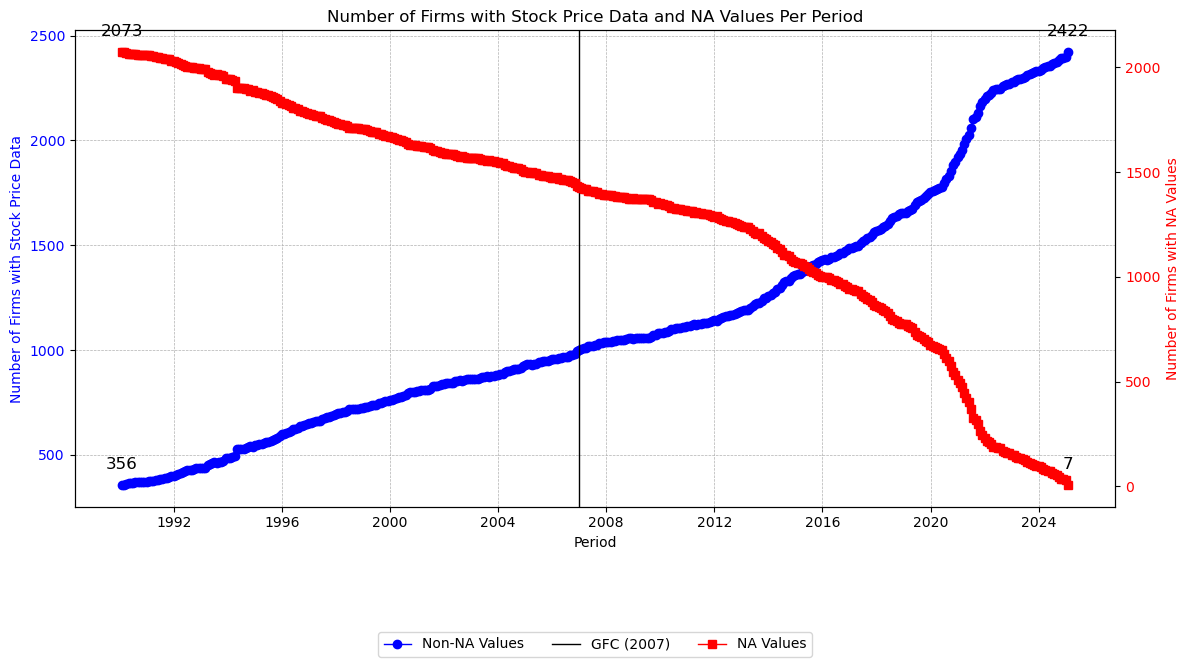

There are 7 firms with no stock price data at the latest period
Hence, 2429 - 2422 = 7
There are discontinuous data for each time period, so we will fix the data sample to the first year of GFC: 2007


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Period' column to datetime for proper plotting
filtered_data["Period"] = pd.to_datetime(filtered_data["Period"]).dt.date

# Sort the dataframe by 'Period' in ascending order (earliest first)
filtered_data = filtered_data.sort_values(by="Period", ascending=True)

# Count non-NA values per period
non_na_counts = filtered_data.set_index("Period").notna().sum(axis=1)

# Count NA values per period
na_counts = filtered_data.set_index("Period").isna().sum(axis=1)

# Find the first and last non-NA value counts
start_date, start_value = non_na_counts.index[0], non_na_counts.iloc[0]
end_date, end_value = non_na_counts.index[-1], non_na_counts.iloc[-1]

# Find the first and last NA value counts
start_na_date, start_na_value = na_counts.index[0], na_counts.iloc[0]
end_na_date, end_na_value = na_counts.index[-1], na_counts.iloc[-1]

# Create the figure and axes for side-by-side plots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot non-NA values (firms with stock price data)
ax1.plot(non_na_counts.index, non_na_counts.values, 
         marker="o", 
         linestyle="-", 
         linewidth=1, 
         label="Non-NA Values", 
         color="blue")

ax1.set_xlabel("Period")
ax1.set_ylabel("Number of Firms with Stock Price Data", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Annotate the start and end points for non-NA values
ax1.text(start_date, start_value + 75, f"{start_value}", fontsize=12, color='black', ha='center')
ax1.text(end_date, end_value + 75, f"{end_value}", fontsize=12, color='black', ha='center')

# Draw a vertical line at the beginning of 2007 to mark the Global Financial Crisis
ax1.axvline(pd.to_datetime("2007-01-01").date(), color='black', linestyle='-', linewidth=1, label="GFC (2007)")

# Create a second y-axis for NA values
ax2 = ax1.twinx()
ax2.plot(na_counts.index, na_counts.values, marker="s", linestyle="-", linewidth=1, label="NA Values", color="red")
ax2.set_ylabel("Number of Firms with NA Values", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Annotate the start and end points for NA values
ax2.text(start_na_date, start_na_value + 75, f"{start_na_value}", fontsize=12, color='black', ha='center')
ax2.text(end_na_date, end_na_value + 75, f"{end_na_value}", fontsize=12, color='black', ha='center')

# Title and grid
plt.title("Number of Firms with Stock Price Data and NA Values Per Period")
ax1.grid(True, linestyle="--", linewidth=0.5)


# Place the legend outside the chart
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

# Print additional information
print("There are 7 firms with no stock price data at the latest period")
print("Hence, 2429 - 2422 = 7")
print("There are discontinuous data for each time period, so we will fix the data sample to the first year of GFC: 2007")

In [17]:
# Identify columns where the last period's data is NA
latest_period = filtered_data["Period"].max()
na_columns = filtered_data.columns[filtered_data[filtered_data["Period"] == latest_period].isna().any()].tolist()
# Display the list of columns with NA in the last period
print("Stocks with NA in the last period:", na_columns)

Stocks with NA in the last period: ['SAIL.O', 'KRMN.K', 'SION.O', 'AARD.O', 'MWYN.O', 'CJMB.O', 'TFFP.O']


In [18]:
# Step 1: Filter data from a specific date onwards
start_filter_date = pd.to_datetime("2007-01-01").date()  # Replace with actual date
filtered_data = filtered_data[filtered_data["Period"] >= start_filter_date]

# Step 2: Drop columns where any row has a blank (NA) value
filtered_adjusted_data = filtered_data.dropna(axis=1, how="any")

# Sort the dataframe by 'Period' in ascending order (earliest first)
filtered_adjusted_data = filtered_adjusted_data.sort_values(by="Period", ascending=True)

# Count non-NA values per period
non_na_counts = filtered_adjusted_data.set_index("Period").notna().sum(axis=1)

# Count NA values per period
na_counts = filtered_adjusted_data.set_index("Period").isna().sum(axis=1)
print(non_na_counts, na_counts)

Period
2007-01-31    977
2007-02-28    977
2007-03-31    977
2007-04-30    977
2007-05-31    977
             ... 
2024-09-30    977
2024-10-31    977
2024-11-30    977
2024-12-31    977
2025-01-31    977
Length: 217, dtype: int64 Period
2007-01-31    0
2007-02-28    0
2007-03-31    0
2007-04-30    0
2007-05-31    0
             ..
2024-09-30    0
2024-10-31    0
2024-11-30    0
2024-12-31    0
2025-01-31    0
Length: 217, dtype: int64


In [19]:
filtered_adjusted_data.head(5)

,Period,AAPL.O,NVDA.O,MSFT.O,AMZN.O,LLY,WMT,XOM,MA,UNH,...,PRSO.O,PALI.O,APDN.O,SBET.O,ASTI.O,AWH.O,SUNE.O,TCRT.O,WINT.O,DGLY.O
216,2007-01-31,3.061783,0.510834,30.8600,1.8835,54.12,15.896651,74.10,11.155,52.26,...,66080.0,3100500.0,374400.0,211.2,5.800000e+13,258.0,17840.18784,799.5,1.423170e+09,288.0
215,2007-02-28,3.021783,0.516667,28.1700,1.9570,52.59,16.103317,71.68,10.718,52.18,...,62160.0,2983500.0,475200.0,205.2,8.320000e+13,195.0,18700.59060,795.0,1.247400e+09,243.2
214,2007-03-31,3.318211,0.479667,27.8700,1.9895,53.71,15.649984,75.45,10.624,52.97,...,67200.0,3744000.0,480000.0,192.0,1.614000e+14,210.0,18331.84656,766.5,1.343790e+09,280.0
213,2007-04-30,3.564282,0.548167,29.9400,3.0665,59.13,15.973317,79.38,11.168,53.06,...,69520.0,4504500.0,408000.0,182.4,1.834000e+14,216.0,19771.70424,804.0,1.683990e+09,384.0
212,2007-05-31,4.328246,0.577317,30.6901,3.4570,58.62,15.866651,83.17,14.955,54.77,...,64479.2,4106700.0,288000.0,172.8,1.402000e+14,175.5,17348.52912,795.0,1.922130e+09,382.4


In [20]:
# Print the number of remaining firm columns (excluding "Period")
print("Total no of firms:", len(filtered_adjusted_data.columns) - 1)

Total no of firms: 977


In [21]:
# Step 3: Identify columns with discontinuous data (missing values in between)
discontinuous_columns = []

for col in filtered_adjusted_data.columns:
    if col != "Period":  # Exclude Period column
        non_na_periods = filtered_adjusted_data[["Period", col]].dropna()["Period"]
        if not non_na_periods.is_monotonic_increasing:  # Check if missing values exist in between
            discontinuous_columns.append(col)

# Print or store the list of columns with discontinuous data
print("Columns with discontinuous data:", discontinuous_columns)

Columns with discontinuous data: []


In [22]:
# Step 5: Now do a monthly log growth rate for all columns
# Sort data by 'Period'
filtered_adjusted_data = filtered_adjusted_data.sort_values(by="Period", ascending=False).set_index('Period')

# Compute monthly log returns and convert to percentage
log_returns = np.log(filtered_adjusted_data / filtered_adjusted_data.shift(-1)) * 100

# Drop the last row (which will contain NaNs after shifting)
log_returns = log_returns.dropna().reset_index()

# rename column for left join later on
log_returns = log_returns.rename(columns = {'Period': 'Date'})

In [23]:
# Step 6: Augmented Dickey-Fuller Test for Stationarity 

# Function to perform ADF test and return p-values
def adf_test(series):
    result = adfuller(series.dropna())  # Drop NaN values before running the test
    return result[1]  # Return the p-value

# Apply ADF test to each column and store the results
adf_results = log_returns.set_index("Date").apply(adf_test)

# Convert results to a DataFrame for better visualization
adf_results_df = pd.DataFrame(adf_results, columns=["p-value"])
adf_results_df["Stationary"] = adf_results_df["p-value"] < 0.05  # True if p-value < 0.05 (stationary)

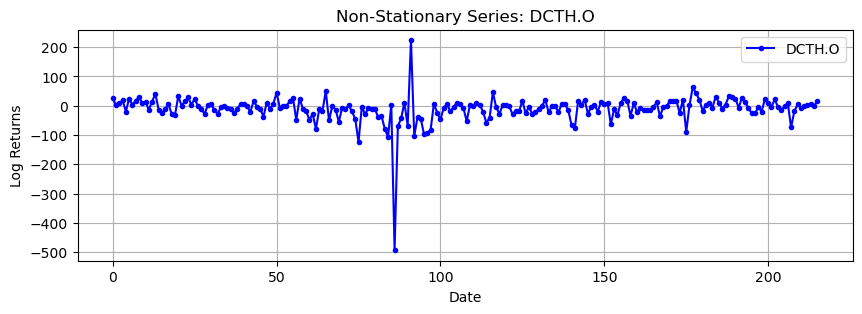

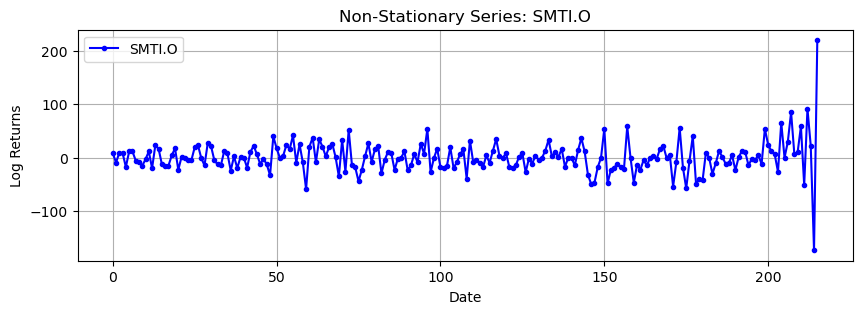

In [24]:
# Isolate non-stationary series (p-value >= 0.05)
non_stationary_series = adf_results_df[adf_results_df["Stationary"] == False].index
non_stationary_data = log_returns[["Date"] + list(non_stationary_series)]

# Plot each non-stationary series
for column in non_stationary_data.columns[1:]:
    plt.figure(figsize=(10, 3))
    plt.plot(non_stationary_data.index, non_stationary_data[column], label=column, color='blue', linestyle='-', marker='.')
    plt.xlabel("Date")
    plt.ylabel("Log Returns")
    plt.title(f"Non-Stationary Series: {column}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
# Step 7: Remove these non-stationary columns from the dataset.
non_stationary_columns = adf_results_df[adf_results_df["Stationary"] == False].index.tolist()

# Remove these columns from log_returns_df and filtered_adjusted_data
final_log_returns = log_returns.drop(columns=non_stationary_columns, errors='ignore')
filtered_adjusted_data = filtered_adjusted_data.drop(columns=non_stationary_columns, errors='ignore').reset_index()


print("No of firms left after cleaning in final_log_returns:", len(final_log_returns.columns)-1)
print("No of firms left after cleaning in filtered_adjusted_data:", len(final_log_returns.columns)-1)

No of firms left after cleaning in final_log_returns: 975
No of firms left after cleaning in filtered_adjusted_data: 975


In [26]:
# Step 8: Melt the data into long format with "Period", "RIC", "Closing Price"
melted_data = filtered_adjusted_data.melt(id_vars=["Period"], var_name="RIC", value_name="Closing Price")

# Step 9: Select relevant columns from search_results for merging
search_results_selected = filtered_search_results_df[["RIC", "SIC Industry Code", "SIC Industry Name", "Company Market Cap"]]

# Step 10: Perform a left join with search_results to add industry and market cap details
merged_data = melted_data.merge(search_results_selected, on="RIC", how="left")

# Step 11: Assign industry based on SIC code
# Function
def assign_industry(sic_code):
    for industry, codes in industry_mapping.items():
        if sic_code in codes:
            return industry
    return "Other"

merged_data["Industry"] = merged_data["SIC Industry Code"].apply(assign_industry)
merged_data.head(5)

,Period,RIC,Closing Price,SIC Industry Code,SIC Industry Name,Company Market Cap,Industry
0,2025-01-31,AAPL.O,236.00,3571.0,Electronic Computers,3.210436e+12,Hi-Tech
1,2024-12-31,AAPL.O,250.42,3571.0,Electronic Computers,3.210436e+12,Hi-Tech
2,2024-11-30,AAPL.O,237.33,3571.0,Electronic Computers,3.210436e+12,Hi-Tech
3,2024-10-31,AAPL.O,225.91,3571.0,Electronic Computers,3.210436e+12,Hi-Tech
4,2024-09-30,AAPL.O,233.00,3571.0,Electronic Computers,3.210436e+12,Hi-Tech


In [27]:
latest_period = merged_data["Period"].max()
filtered_last_period = merged_data[merged_data["Period"] == latest_period]

# Step 12: Calculate total market cap by industry (excluding NaN values)
industry_market_cap = filtered_last_period.groupby("Industry")["Company Market Cap"].sum(min_count=1).reset_index()
industry_market_cap.columns = ["Industry", "Total Latest Market Capitalisation"]
# Sort the dataframe by 'Period' in ascending order (earliest first)
industry_market_cap = industry_market_cap.sort_values(by="Total Latest Market Capitalisation", ascending=False)
industry_market_cap["Percentage"] = (industry_market_cap["Total Latest Market Capitalisation"] / 
                                    industry_market_cap["Total Latest Market Capitalisation"].sum()) * 100

industry_market_cap

,Industry,Total Latest Market Capitalisation,Percentage
2,Hi-Tech,1.344264e+13,46.754854
0,Consumer,5.076649e+12,17.657095
3,Manufacturing,3.567610e+12,12.408504
4,Other,3.505050e+12,12.190914
1,Healthcare,3.159378e+12,10.988633


In [28]:
# Step 13: Count the number of unique RICs per industry
industry_ric_count = filtered_last_period.groupby("Industry")["RIC"].nunique().reset_index()
industry_ric_count.columns = ["Industry", "Number of Firms"]
industry_ric_count["Percentage"] = (industry_ric_count["Number of Firms"] / 
                                    industry_ric_count["Number of Firms"].sum()) * 100

# Sort the dataframe by 'Period' in ascending order (earliest first)
industry_ric_count = industry_ric_count.sort_values(by="Number of Firms", ascending=False)

# Check
assert industry_ric_count["Number of Firms"].sum() == len(filtered_adjusted_data.columns) - 1
industry_ric_count

,Industry,Number of Firms,Percentage
2,Hi-Tech,243,24.923077
4,Other,210,21.538462
3,Manufacturing,188,19.282051
1,Healthcare,187,19.179487
0,Consumer,147,15.076923


### 3 factor FF dataframe

In [29]:
# Convert both 'Date' columns to datetime
final_log_returns['Date'] = pd.to_datetime(final_log_returns['Date'])
ff_3_factors['Date'] = pd.to_datetime(ff_3_factors['Date'])

# Convert ff_3_factors['Date'] to month-end
ff_3_factors['Date'] = ff_3_factors['Date'] + pd.offsets.MonthEnd(0)

# Perform the left join
three_ff_cleaned_df = pd.merge(final_log_returns, ff_3_factors, on='Date', how='left').dropna()
# Convert all columns except 'Date' to float
three_ff_cleaned_df.iloc[:, 1:] = three_ff_cleaned_df.iloc[:, 1:].astype(float)
# Preview the result
three_ff_cleaned_df.head(4)

,Date,AAPL.O,NVDA.O,MSFT.O,AMZN.O,LLY,WMT,XOM,MA,UNH,...,ASTI.O,AWH.O,SUNE.O,TCRT.O,WINT.O,DGLY.O,Mkt-RF,SMB,HML,RF
1,2024-12-31,5.368793,-2.906200,-0.463928,5.384187,-2.979772,-2.351763,-9.220379,-1.202457,-18.752682,...,20.271151,-23.302366,-19.928709,-30.330739,-41.788881,-39.532439,-3.17,-2.73,-2.95,0.37
2,2024-11-30,4.931489,4.052065,4.124420,10.911419,-4.233013,12.109934,1.005376,6.462109,7.784639,...,-17.794244,-1.117330,-20.490979,22.994961,-28.210576,-18.658596,6.51,4.63,-0.05,0.40
3,2024-10-31,-3.090176,8.912267,-5.726778,0.037561,-6.553683,1.475134,-0.376069,1.165719,-3.512431,...,22.001366,10.536052,-53.167279,-45.154157,-122.312292,-10.109612,-0.97,-1.01,0.89,0.39
4,2024-09-30,1.731645,1.719240,3.106074,4.293069,-8.030489,4.456998,-0.612351,2.141024,-0.939677,...,-20.102575,-24.027983,-176.326895,21.772348,-122.180450,-5.608947,1.74,-0.17,-2.59,0.40


### 5 factor FF dataframe

In [30]:
# Convert both 'Date' columns to datetime
final_log_returns['Date'] = pd.to_datetime(final_log_returns['Date'])
ff_5_factors['Date'] = pd.to_datetime(ff_5_factors['Date'])

# Convert ff_3_factors['Date'] to month-end
ff_5_factors['Date'] = ff_5_factors['Date'] + pd.offsets.MonthEnd(0)

# Perform the left join
five_ff_cleaned_df = pd.merge(final_log_returns, ff_5_factors, on='Date', how='left').dropna()
# Convert all columns except 'Date' to float
five_ff_cleaned_df.iloc[:, 1:] = five_ff_cleaned_df.iloc[:, 1:].astype(float)
# Preview the result
five_ff_cleaned_df.head(4)

,Date,AAPL.O,NVDA.O,MSFT.O,AMZN.O,LLY,WMT,XOM,MA,UNH,...,SUNE.O,TCRT.O,WINT.O,DGLY.O,Mkt-RF,SMB,HML,RMW,CMA,RF
1,2024-12-31,5.368793,-2.906200,-0.463928,5.384187,-2.979772,-2.351763,-9.220379,-1.202457,-18.752682,...,-19.928709,-30.330739,-41.788881,-39.532439,-3.17,-3.87,-2.95,1.82,-1.10,0.37
2,2024-11-30,4.931489,4.052065,4.124420,10.911419,-4.233013,12.109934,1.005376,6.462109,7.784639,...,-20.490979,22.994961,-28.210576,-18.658596,6.51,4.78,-0.05,-2.62,-2.17,0.40
3,2024-10-31,-3.090176,8.912267,-5.726778,0.037561,-6.553683,1.475134,-0.376069,1.165719,-3.512431,...,-53.167279,-45.154157,-122.312292,-10.109612,-0.97,-0.88,0.89,-1.38,1.03,0.39
4,2024-09-30,1.731645,1.719240,3.106074,4.293069,-8.030489,4.456998,-0.612351,2.141024,-0.939677,...,-176.326895,21.772348,-122.180450,-5.608947,1.74,-1.02,-2.59,0.04,-0.26,0.40
